# Cap√≠tulo 6 ‚Äì Implementa√ß√£o de Filtros em Tempo Discreto

Nos cap√≠tulos anteriores estudamos a teoria dos sistemas discretos nos dom√≠nios do tempo e da frequ√™ncia. Agora, utilizaremos essa teoria para o **processamento de sinais digitais**.

Para processar sinais, precisamos projetar e implementar sistemas chamados **filtros** (ou **analisadores de espectro**, em certos contextos). A escolha do projeto do filtro √© influenciada por fatores como:

- O **tipo de filtro** (FIR ou IIR)
- A **forma de implementa√ß√£o** (estruturas de realiza√ß√£o)

Por isso, **antes de discutirmos o projeto dos filtros**, focamos em como **essas estruturas podem ser implementadas na pr√°tica**, o que √© essencial, pois diferentes estruturas imp√µem estrat√©gias distintas de projeto.

Al√©m de descrever diferentes estruturas de filtros, tamb√©m come√ßamos a considerar **problemas relacionados √† quantiza√ß√£o**, que ocorrem devido ao uso de **aritm√©tica de precis√£o finita** nos dispositivos digitais. Tanto os **coeficientes** dos filtros quanto as **opera√ß√µes de filtragem** sofrem os efeitos dessa limita√ß√£o, tanto em implementa√ß√µes por hardware quanto por software.

Come√ßaremos com a descri√ß√£o dos **blocos b√°sicos** usados para representar estruturas de filtros. Em seguida, abordaremos brevemente as estruturas de filtros **IIR**, **FIR** e **em rede (lattice)**, com **fun√ß√µes MATLAB/Python** correspondentes. Por fim, estudaremos a **representa√ß√£o num√©rica**, a **caracteriza√ß√£o dos erros** e os efeitos da **quantiza√ß√£o dos coeficientes**.


# 6.1 ‚Äì Elementos B√°sicos (Basic Elements)

Como nossos filtros digitais s√£o sistemas LTI (lineares e invariantes no tempo), podemos represent√°-los utilizando tr√™s elementos fundamentais. Esses blocos formam a base para a constru√ß√£o de estruturas de filtros digitais, como ser√° visto nos pr√≥ximos t√≥picos.

### 1. Somador (Adder)
Elemento com **duas entradas** e **uma sa√≠da**, utilizado para somar sinais. A soma de tr√™s ou mais sinais pode ser feita encadeando somadores de duas entradas.

### 2. Multiplicador (Ganho)
Elemento com **uma entrada** e **uma sa√≠da**, que multiplica o sinal por um coeficiente. A multiplica√ß√£o por 1 √© impl√≠cita e geralmente omitida no diagrama.

### 3. Elemento de Atraso (Delay ou Mem√≥ria)
Elemento que **atrasa o sinal em uma unidade de tempo amostral**. Este atraso √© implementado atrav√©s de registradores de deslocamento (shift registers) e representa a opera√ß√£o \( z^{-1} \).

A partir desses tr√™s blocos √© poss√≠vel implementar qualquer estrutura de filtro FIR ou IIR.

## 6.2 Estruturas de Filtro IIR

A fun√ß√£o de sistema de um filtro IIR (Infinite Impulse Response) √© dada por:

$$ H(z) = \frac{B(z)}{A(z)} = \frac{\sum_{n=0}^{M} b_n z^{-n}}{\sum_{n=0}^{N} a_n z^{-n}} = \frac{b_0 + b_1 z^{-1} + \cdots + b_M z^{-M}}{1 + a_1 z^{-1} + \cdots + a_N z^{-N}} $$

onde $b_n$ e $a_n$ s√£o os coeficientes do filtro. Assume-se sem perda de generalidade que $a_0 = 1$. A ordem de um filtro IIR √© $N$ se $a_N \neq 0$.

A representa√ß√£o da equa√ß√£o de diferen√ßas de um filtro IIR √© expressa como:

$$ y(n) = \sum_{m=0}^{M} b_m x(n-m) - \sum_{m=1}^{N} a_m y(n-m) $$

Esta equa√ß√£o mostra que a sa√≠da atual $y(n)$ depende das amostras de entrada atuais e passadas $x(n-m)$, bem como das amostras de sa√≠da passadas $y(n-m)$.

Existem 3 estruturas que podem ser usadas para implementar um filtro IIR:

- Forma Direta:
  Como o nome sugere, a equa√ß√£o de diferen√ßas √© implementada exatamente como est√°, utilizando blocos de **atraso**, **multiplicadores** e **somadores**.

  Para fins de ilustra√ß√£o, considere $M = N = 4$. A equa√ß√£o de diferen√ßas associada √©:

  $$
  y(n) = b_0 x(n) + b_1 x(n-1) + b_2 x(n-2) + b_3 x(n-3) + b_4 x(n-4) \\
  \quad - a_1 y(n-1) - a_2 y(n-2) - a_3 y(n-3) - a_4 y(n-4)
  $$

  Essa equa√ß√£o pode ser implementada diretamente em duas formas principais:

  - **Forma Direta I**: Implementa separadamente as partes do numerador e denominador da fun√ß√£o racional $H(z)$ com uma conex√£o em cascata entre elas. O numerador √© realizado por uma linha de atraso com ramifica√ß√µes (tapped delay line), e o denominador por uma linha de atraso com realimenta√ß√£o. Como resultado, essa forma utiliza **duas linhas de atraso separadas**, totalizando **8 elementos de atraso** para $N=4$.

  - **Forma Direta II**: Otimiza a estrutura anterior **reduzindo o n√∫mero de elementos de atraso**. Isso √© feito ao unir as duas linhas de atraso em uma s√≥, conectadas por um ramo de ganho unit√°rio. A estrutura resultante √© chamada de **forma can√¥nica**, pois usa o **n√∫mero m√≠nimo de atrasos** necess√°rio para implementar o sistema. Embora ambas as formas sejam **equivalentes do ponto de vista entrada-sa√≠da**, os sinais internos s√£o diferentes.

- Forma em Cascata:
  Na **forma em cascata**, a fun√ß√£o de sistema $H(z)$ √© expressa como um **produto de se√ß√µes de segunda ordem** com coeficientes reais. Esse processo √© feito por meio da **fatora√ß√£o dos polin√¥mios do numerador e denominador** em suas ra√≠zes, agrupando pares complexos conjugados ou dois polos reais em **polin√¥mios de 2¬™ ordem**.

  Assumindo que $N$ √© par, podemos escrever:

  $$
  H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_N z^{-N}}{1 + a_1 z^{-1} + \cdots + a_N z^{-N}} = b_0 \prod_{k=1}^{K} \frac{1 + B_{k,1} z^{-1} + B_{k,2} z^{-2}}{1 + A_{k,1} z^{-1} + A_{k,2} z^{-2}}
  $$

  Onde:

  - $K = N/2$
  - $B_{k,1}, B_{k,2}, A_{k,1}, A_{k,2}$ s√£o coeficientes reais correspondentes √†s se√ß√µes de segunda ordem
  - Cada **se√ß√£o biquadr√°tica** $H_k(z)$ (ou *biquad*) √© dada por:

  $$
  H_k(z) = \frac{Y_{k+1}(z)}{Y_k(z)} = \frac{1 + B_{k,1} z^{-1} + B_{k,2} z^{-2}}{1 + A_{k,1} z^{-1} + A_{k,2} z^{-2}} \quad \text{para } k = 1, \dots, K
  $$

  - A entrada da se√ß√£o $k$ √© a sa√≠da da se√ß√£o $k-1$:  
    $Y_1(z) = b_0 X(z)$  
    $Y_{K+1}(z) = Y(z)$

  Cada biquad pode ser implementado usando a **forma direta II**. A estrutura final do filtro √© uma **cascata de se√ß√µes biquadr√°ticas**.

  Essa abordagem oferece diversas vantagens pr√°ticas, como:

  - **Maior estabilidade num√©rica**, especialmente em ambientes de precis√£o finita
  - **Redu√ß√£o dos efeitos de quantiza√ß√£o**
  - **Facilidade de ajuste** de cada se√ß√£o individual

- Forma Paralela:
  Na **forma paralela**, a fun√ß√£o de sistema $H(z)$ √© decomposta em uma **soma de se√ß√µes racionais de ordem menor**, geralmente **de 1¬™ e 2¬™ ordem**. Essa abordagem √© baseada na t√©cnica de **decomposi√ß√£o em fra√ß√µes parciais**, que representa a fun√ß√£o racional como uma soma de termos simples.

  A fun√ß√£o $H(z)$, definida como:

  $$
  H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_N z^{-N}}{1 + a_1 z^{-1} + \cdots + a_N z^{-N}}
  $$

  pode ser expressa como:

  $$
  H(z) = H_1(z) + H_2(z) + \cdots + H_K(z) + H_{z}(z)
  $$

  Onde:

  - Cada $H_k(z)$ √© uma **se√ß√£o de segunda ordem**, da forma:

  $$
  H_k(z) = \frac{B_{k,1} z^{-1} + B_{k,2} z^{-2}}{1 + A_{k,1} z^{-1} + A_{k,2} z^{-2}}
  $$

  - $H_z(z)$ √© um **termo direto**, representando a parte que n√£o participa da realimenta√ß√£o (feedforward direto).

  Essa decomposi√ß√£o √© √∫til porque:

  - **Permite implementa√ß√£o independente** de cada termo, o que pode facilitar a paraleliza√ß√£o em hardware ou software.
  - Oferece **maior controle num√©rico**, sendo √∫til em contextos onde a precis√£o √© cr√≠tica.
  - Pode ser mais eficiente quando poucos polos dominam o comportamento do sistema.

  A forma paralela √© especialmente vantajosa para filtros IIR com **ra√≠zes bem separadas**, onde os termos individuais podem ser tratados como sistemas independentes de baixa ordem.


## Exemplo 6.1

In [2]:
import numpy as np
from scipy.signal import tf2sos, sosfreqz
from numpy.polynomial.polynomial import Polynomial

# Coeficientes da equa√ß√£o (direta)
b = np.array([1, -3, 11, -27, 18])
a = np.array([16, 12, 2, -4, -1])

# Normaliza os coeficientes
b0 = b[0]
a0 = a[0]
b = b / b0
a = a / a0
gain = b0 / a0  # equivalente ao b0 na fun√ß√£o do livro

# Igualando os comprimentos dos vetores
N = max(len(b), len(a))
b = np.pad(b, (0, N - len(b)))
a = np.pad(a, (0, N - len(a)))

# Converte para forma cascata (SOS)
sos = tf2sos(b, a)

# Extrai matrizes B e A dos biquads
B = sos[:, :3]
A = sos[:, 3:]

# Mostra resultados no estilo do livro
print(f"b0 (ganho global): {gain}")
print("\nBiquads Numerador (B):")
print(B)
print("\nBiquads Denominador (A):")
print(A)


b0 (ganho global): 0.0625

Biquads Numerador (B):
[[ 1.00000000e+00  9.99200722e-16  9.00000000e+00]
 [ 1.00000000e+00 -3.00000000e+00  2.00000000e+00]]

Biquads Denominador (A):
[[ 1.    -0.25  -0.125]
 [ 1.     1.     0.5  ]]


## Exemplo 6.2

In [4]:
from scipy.signal import residuez

# Coeficientes da forma direta
b = np.array([1, -3, 11, -27, 18], dtype=np.float64)
a = np.array([16, 12, 2, -4, -1], dtype=np.float64)

# Decomposi√ß√£o via Res√≠duos Parciais
r, p, C = residuez(b, a)  # r = res√≠duos, p = polos, C = parte polinomial (caso M ‚â• N)

# Ordena os polos (cplxpair) ‚Äî por parte real depois imagin√°ria
def cplxpair(z):
    z = np.array(z)
    return z[np.lexsort((np.imag(z), np.real(z)))]

p_sorted = cplxpair(p)
r_sorted = r[np.argsort(np.lexsort((np.imag(p), np.real(p))))]

# Agrupa res√≠duos e polos em pares para obter coeficientes de segunda ordem
B = []
A = []

i = 0
while i < len(p_sorted):
    if i+1 < len(p_sorted) and np.iscomplex(p_sorted[i]):
        # Par de complexos conjugados ‚Üí biquad
        pk = [p_sorted[i], p_sorted[i+1]]
        rk = [r_sorted[i], r_sorted[i+1]]
        # Constr√≥i os coeficientes do denominador: (1 - p1 z^-1)(1 - p2 z^-1) = 1 - (p1+p2)z^-1 + p1p2 z^-2
        a_poly = np.array([1, -(pk[0] + pk[1]), pk[0] * pk[1]]).real
        # Constr√≥i o numerador: r1/(1-p1 z^-1) + r2/(1-p2 z^-1) = (r1(1-p2 z^-1) + r2(1-p1 z^-1)) / ((1-p1 z^-1)(1-p2 z^-1))
        # Numerador: (r1+r2) + (-r1*p2 - r2*p1)z^-1
        b_poly = np.array([rk[0] + rk[1], -rk[0]*pk[1] - rk[1]*pk[0]]).real
        B.append(b_poly)
        A.append(a_poly)
        i += 2
    else:
        # Polo real ‚Üí filtro de 1¬™ ordem
        pk = [p_sorted[i]]
        rk = [r_sorted[i]]
        # Denominador: 1 - p1 z^-1
        a_poly = np.array([1, -pk[0]]).real
        # Numerador: r1
        b_poly = np.array([rk[0]]).real
        B.append(b_poly)
        A.append(a_poly)
        i += 1

# Lidar com a parte polinomial (C)
if len(C) > 0:
    # C √© o ganho direto ou um termo polinomial em z. Para H(z) = sum(Hi(z)) + C,
    # C √© simplesmente adicionado em paralelo. Se C √© um vetor, representa
    # um termo polinomial em z^-1.
    # Neste caso, residuez retorna C como um array para termos z^0, z^-1, ...
    # Se C √© apenas um escalar, representa um ganho direto.
    # Se M>=N, C pode ter mais de um termo. Vamos adicionar como termos de 1¬™ ordem (ou ordem 0 se for s√≥ C[0])
    for j in range(len(C)):
        if abs(C[j]) > 1e-9: # Adicionar apenas se o coeficiente n√£o for desprez√≠vel
             # Considerar C[0] como ganho direto
             # Se len(C) > 1, os termos C[j]z^(-j) s√£o termos de feedforward direto
             # que podem ser representados como se√ß√µes de ordem 0 ou 1
             if j == 0: # Termo constante
                 B.append(np.array([C[j]]).real)
                 A.append(np.array([1]).real)
             else: # Termo z^(-j)
                 # Este √© um feedforward direto. Para a forma paralela,
                 # podemos trat√°-lo como um termo com denominador 1
                 b_c = np.zeros(j+1)
                 b_c[j] = C[j].real
                 B.append(b_c)
                 A.append(np.array([1]).real)


# Imprime os coeficientes B e A das se√ß√µes em paralelo
print("Coeficientes Numerador (B) das Se√ß√µes Paralelas:")
for b_sec in B:
    print(b_sec)

print("\nCoeficientes Denominador (A) das Se√ß√µes Paralelas:")
for a_sec in A:
    print(a_sec)

# O termo C (se existir e n√£o for zero) √© um ganho direto que √© somado √† sa√≠da.
# Para este exemplo espec√≠fico, M=N, ent√£o C deve ser um escalar representando o ganho direto.
# De acordo com a documenta√ß√£o do residuez, C √© o termo direto, que pode ser
# um array de coeficientes de z^0, z^-1, ... se M>=N.
# Vamos verificar o valor de C neste caso
print("\nTermo Direto (C):")
print(C)

Coeficientes Numerador (B) das Se√ß√µes Paralelas:
[-10.05  -6.1 ]
[0.925]
[27.1875]
[-18.]

Coeficientes Denominador (A) das Se√ß√µes Paralelas:
[1.  1.  0.5]
[1.   0.25]
[ 1.  -0.5]
[1]

Termo Direto (C):
[-18.]


## 6.3 Estruturas de Filtros FIR

Os filtros FIR (Finite Impulse Response) s√£o filtros com resposta ao impulso de dura√ß√£o finita, definidos por um sistema da forma:

$$ H(z) = b_0 + b_1 z^{-1} + \cdots + b_{M-1} z^{-(M-1)} = \sum_{n=0}^{M-1} b_n z^{-n} $$

A resposta ao impulso associada √©:

$$ h(n) = \begin{cases} b_n, & 0 \leq n \leq M-1 \\ 0, & \text{caso contr√°rio} \end{cases} $$

E a equa√ß√£o de diferen√ßas que implementa esse filtro √©:

$$ y(n) = b_0 x(n) + b_1 x(n-1) + \cdots + b_{M-1} x(n-M+1) $$

Essa equa√ß√£o representa uma convolu√ß√£o linear de suporte finito entre a entrada $x(n)$ e a resposta ao impulso $h(n)$.

### Caracter√≠sticas dos Filtros FIR:

*   **Ordem:** $M-1$
*   **Comprimento:** $M$ (n√∫mero de coeficientes)
*   **Estabilidade garantida:** pois n√£o h√° polos dentro ou fora do c√≠rculo unit√°rio (exceto na origem).
*   Permitem **fase linear** (ou seja, aus√™ncia de distor√ß√£o de fase), que √© uma propriedade desej√°vel em muitas aplica√ß√µes, como processamento de √°udio, imagens ou comunica√ß√µes digitais.

### Estruturas de Implementa√ß√£o FIR

Existem quatro formas cl√°ssicas para implementar um filtro FIR:

1.  **Forma Direta (Direct Form)**
    Implementa√ß√£o direta da equa√ß√£o de diferen√ßas. Simples e direta, mas sem otimiza√ß√µes.

2.  **Forma em Cascata (Cascade Form)**
    O sistema $H(z)$ √© fatorado em termos de fatores de segunda ordem (ou primeira ordem, se necess√°rio), implementados em s√©rie. Melhora a robustez num√©rica em alguns casos.

3.  **Forma de Fase Linear (Linear-Phase Form)**
    Explora a simetria da resposta ao impulso em filtros de fase linear (sim√©trica ou anti-sim√©trica) para reduzir o n√∫mero de multiplica√ß√µes pela metade, aumentando a efici√™ncia computacional.

4.  **Forma Paralela (Parallel Form)**
    Embora menos comum para filtros FIR do que para IIR, a forma paralela decomp√µe $H(z)$ em uma soma de sub-sistemas de ordem menor. Cada sub-sistema pode ser implementado independentemente e suas sa√≠das somadas.

## EXEMPLO 6.4 ‚Äì Filtro FIR: Formas Direta, de Fase Linear e em Cascata

Considere o filtro FIR descrito pela fun√ß√£o de sistema:

$$ H(z) = 1 + 16,0625 z^{-4} + z^{-8} $$

a) **Forma Direta**
A equa√ß√£o de diferen√ßas associada √©:

$$ y(n) = x(n) + 16,0625 \cdot x(n-4) + x(n-8) $$

Essa forma implementa diretamente a equa√ß√£o de convolu√ß√£o. Ela utiliza 8 registros de atraso, com multiplica√ß√µes apenas nos coeficientes n√£o-nulos.

b) **Forma de Fase Linear**
Devido √† simetria da resposta ao impulso (coeficientes sim√©tricos em torno de $n=4$), podemos reescrever a equa√ß√£o como:

$$ y(n) = [x(n) + x(n-8)] + 16,0625 \cdot x(n-4) $$

A estrutura de fase linear utiliza somas sim√©tricas para explorar essa propriedade, reduzindo o n√∫mero de multiplica√ß√µes.

c) **Forma em Cascata**
Fatorando $H(z)$, obtemos uma decomposi√ß√£o em fatores de 2¬™ ordem:

$$ H(z) = (z^{-4} + 1)^2 $$

A forma em cascata representa esses fatores como blocos de filtro conectados em s√©rie. Essa abordagem pode ser mais eficiente numericamente e modular.

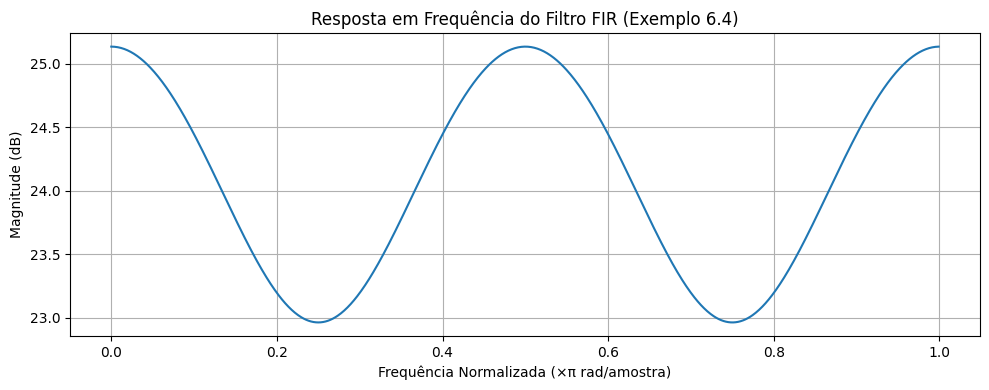

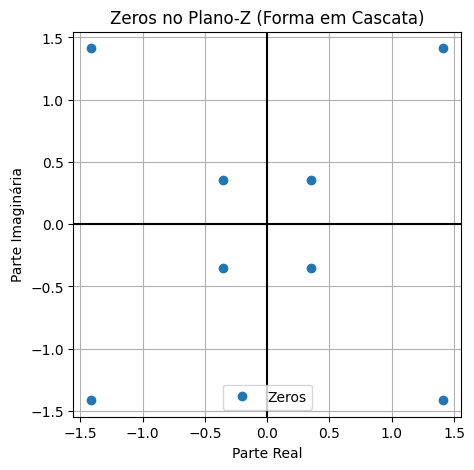

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, tf2zpk

# Coeficientes do filtro FIR
b = [1, 0, 0, 0, 16.0625, 0, 0, 0, 1]  # x(n), x(n-4), x(n-8)
a = [1]  # Filtro FIR: denominador √© 1

# Resposta em frequ√™ncia
w, h = freqz(b, a, worN=1024)
plt.figure(figsize=(10, 4))
plt.plot(w / np.pi, 20 * np.log10(np.abs(h)), label="|H(e^jœâ)| [dB]")
plt.title("Resposta em Frequ√™ncia do Filtro FIR (Exemplo 6.4)")
plt.xlabel("Frequ√™ncia Normalizada (√óœÄ rad/amostra)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Zeros e polos (para cascata)
z, p, k = tf2zpk(b, a)
plt.figure(figsize=(5, 5))
plt.plot(np.real(z), np.imag(z), 'o', label='Zeros')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title("Zeros no Plano-Z (Forma em Cascata)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imagin√°ria")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


## EXEMPLO 6.6 ‚Äì Forma de Amostragem em Frequ√™ncia

Seja o filtro FIR com resposta ao impulso:

$$ h(n) = \frac{1}{9} \cdot \{1, 2, 3, 2, 1\} $$

Este filtro possui comprimento $M=5$, o que significa que ele √© de ordem 4. Desejamos representar o filtro na forma de amostragem em frequ√™ncia, baseada na DFT dos coeficientes $h(n)$.

A forma de amostragem em frequ√™ncia reconstr√≥i a fun√ß√£o de sistema a partir de pares de se√ß√µes paralelas de 2¬™ ordem (quando $M$ √© √≠mpar) ou pares sim√©tricos (quando $M$ √© par), com base na DFT dos coeficientes.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Resposta ao impulso
h = np.array([1, 2, 3, 2, 1]) / 9
M = len(h)

# DFT da resposta ao impulso
H = np.fft.fft(h, M)
magH = np.abs(H)
phaH = np.angle(H)

# Exibir resultados (equivalente ao script MATLAB)
print("DFT H[k]:")
for k in range(M):
    print(f"H[{k}] = {H[k]:.4f} (|H| = {magH[k]:.4f}, ‚à†H = {phaH[k]:.4f} rad)")

# Estrutura baseada na fun√ß√£o dir2fs (aproxima√ß√£o)
L = (M - 1) // 2  # M √≠mpar
k = np.arange(1, L + 1)

# Coeficientes do denominador A (se√ß√µes de 2¬™ ordem)
A = np.ones((L, 3))
A[:, 1] = -2 * np.cos(2 * np.pi * k / M)

# Coeficientes do numerador B
B = np.zeros((L, 2))
B[:, 0] = np.cos(phaH[1:L + 1])
B[:, 1] = -np.cos(phaH[1:L + 1] - 2 * np.pi * k / M)

# Coeficientes de ganho C
C = np.concatenate(([2 * magH[1]], [2 * magH[2]], [np.real(H[0])]))

# Resultados
print("\nCoeficientes C (ganhos):")
print(np.round(C, 4))

print("\nCoeficientes B (numeradores):")
print(np.round(B, 4))

print("\nCoeficientes A (denominadores):")
print(np.round(A, 4))


DFT H[k]:
H[0] = 1.0000+0.0000j (|H| = 1.0000, ‚à†H = 0.0000 rad)
H[1] = -0.2353-0.1710j (|H| = 0.2909, ‚à†H = -2.5133 rad)
H[2] = 0.0131+0.0404j (|H| = 0.0424, ‚à†H = 1.2566 rad)
H[3] = 0.0131-0.0404j (|H| = 0.0424, ‚à†H = -1.2566 rad)
H[4] = -0.2353+0.1710j (|H| = 0.2909, ‚à†H = 2.5133 rad)

Coeficientes C (ganhos):
[0.5818 0.0849 1.    ]

Coeficientes B (numeradores):
[[-0.809  0.809]
 [ 0.309 -0.309]]

Coeficientes A (denominadores):
[[ 1.    -0.618  1.   ]
 [ 1.     1.618  1.   ]]


### üìò 6.4 ‚Äì Estruturas de Filtros em Malha (*Lattice Filter Structures*)

A estrutura de filtro em malha, conhecida como **lattice filter**, √© amplamente utilizada em aplica√ß√µes de **processamento digital de fala** e na implementa√ß√£o de **filtros adaptativos**. Seu uso √© preferido em v√°rias situa√ß√µes por apresentar vantagens estruturais e num√©ricas, especialmente quando h√° necessidade de modelagem eficiente e est√°vel de sistemas din√¢micos.

---

#### üîß Vantagens do Filtro em Malha

- **Estabilidade inerente**: estruturas em malha tendem a ser mais robustas frente a efeitos de quantiza√ß√£o e erros num√©ricos, o que √© desej√°vel em sistemas em tempo real.
- **Modularidade**: os filtros em malha s√£o compostos por est√°gios simples, permitindo f√°cil expans√£o e an√°lise.
- **Aplica√ß√µes em fala**: como em an√°lise e s√≠ntese de voz, onde apenas um pequeno n√∫mero de coeficientes pode representar uma grande quantidade de **formantes** (picos de resson√¢ncia), facilitando implementa√ß√µes em tempo real.

---

#### üîÄ Tipos de Estruturas

- **Lattice All-Zero (FIR)**  
  √â a representa√ß√£o FIR da estrutura em malha, tamb√©m chamada de **lattice filter**.  
  Ela possui somente **zeros** e √© usada em casos onde a resposta ao impulso √© de dura√ß√£o finita.

- **Lattice Ladder (IIR)**  
  Representa a forma **IIR** da estrutura, tamb√©m conhecida como **lattice ladder**.  
  Esta forma cont√©m **zeros e polos**, permitindo uma modelagem mais completa e flex√≠vel, especialmente em sinais com respostas impulsivas de dura√ß√£o infinita.

---

#### üìå Resumo

| Tipo de Estrutura | Tipo de Filtro | Caracter√≠stica Principal                  |
|-------------------|----------------|-------------------------------------------|
| Lattice (All-Zero) | FIR            | Estrutura com resposta ao impulso finita  |
| Lattice Ladder     | IIR            | Estrutura com resposta ao impulso infinita|

---


### ‚úÖ EXEMPLO 6.5 ‚Äì Convers√£o para Estrutura em Malha (Lattice Filter)

Considere o filtro FIR descrito pela equa√ß√£o de diferen√ßas:

$$
y(n) = 2x(n) + \frac{13}{12}x(n-1) + \frac{5}{4}x(n-2) + \frac{2}{3}x(n-3)
$$

Nosso objetivo √© converter esse filtro para a **estrutura em malha all-zero**, ou seja, obter os **coeficientes de reflex√£o \( K \)** do filtro lattice.


In [1]:
import numpy as np

def dir2latc(b):
    """
    Convers√£o de Forma Direta FIR para Forma Lattice All-Zero
    K = dir2latc(b)
    K: coeficientes de reflex√£o (estrutura lattice)
    b: coeficientes FIR da forma direta (resposta ao impulso)
    """
    M = len(b)
    K = np.zeros(M)
    b1 = b[0]

    if b1 == 0:
        raise ValueError("b[0] √© igual a zero")

    K[0] = b1
    A = b / b1

    for m in range(M-1, 0, -1):
        K[m] = A[m]
        J = np.flip(A)
        A = (A - K[m] * J) / (1 - K[m] * K[m])
        A = A[:m]

    return K

# Coeficientes do exemplo do livro
b = np.array([2, 13/12, 5/4, 2/3])
K = dir2latc(b)
print("Coeficientes da estrutura lattice (K):", K)


Coeficientes da estrutura lattice (K): [2.         0.25       0.5        0.33333333]


## Estrutura Lattice-Ladder

A estrutura *lattice-ladder* √© uma representa√ß√£o comum para filtros IIR (Infinite Impulse Response), sendo √∫til principalmente em aplica√ß√µes de processamento de fala e filtros adaptativos.

A forma *lattice* representa a parte recursiva (*denominador*) do filtro, enquanto a parte *ladder* representa a parte n√£o recursiva (*numerador*). A fun√ß√£o de sistema de um filtro IIR √© dada por:

$$
H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_M z^{-M}}{a_0 + a_1 z^{-1} + \cdots + a_N z^{-N}}
$$

A convers√£o para a estrutura *lattice-ladder* envolve dois vetores de coeficientes:

- $K = [K_1, K_2, \ldots, K_{N-1}]$: coeficientes de reflex√£o da estrutura *lattice*
- $C = [C_0, C_1, \ldots, C_N]$: coeficientes da estrutura *ladder*

Esses coeficientes podem ser calculados a partir dos coeficientes $a$ (denominador) e $b$ (numerador) do filtro IIR.

---
### **Exemplo 6.8**

Considere o filtro IIR:

$$
H(z) = \frac{1 + 2z^{-1} + 2z^{-2} + z^{-3}}{1 + \frac{13}{24}z^{-1} + \frac{5}{8}z^{-2} + \frac{1}{3}z^{-3}}
$$

Seus coeficientes s√£o:

- $b = [1, 2, 2, 1]$
- $a = [1, \frac{13}{24}, \frac{5}{8}, \frac{1}{3}]$

A estrutura *lattice-ladder* pode ser obtida a partir desses coeficientes.


In [2]:
import numpy as np

def dir2ladr(b, a):
    """
    Convers√£o de forma direta para estrutura lattice-ladder (IIR)
    b: coeficientes do numerador
    a: coeficientes do denominador
    Retorna:
        K: coeficientes da parte lattice
        C: coeficientes da parte ladder
    """
    b = np.array(b, dtype=float)
    a = np.array(a, dtype=float)
    a = a / a[0]
    b = b / a[0]

    M = len(b)
    N = len(a)

    if M > N:
        raise ValueError("O comprimento de b deve ser menor ou igual ao de a.")

    b = np.concatenate([b, np.zeros(N - M)])
    K = np.zeros(N - 1)
    C = b.copy()
    A = np.zeros((N - 1, N - 1))

    for m in range(N - 1, 0, -1):
        A[m - 1, :m] = -a[1:m + 1] * C[m]
        K[m - 1] = a[m]
        J = a[::-1]
        a = (a - K[m - 1] * J) / (1 - K[m - 1] ** 2)
        a = a[:m]
        if m < N - 1:
            C[m - 1] = b[m - 1] + np.sum(np.diag(A[m:N - 1, :N - m]))
        else:
            C[m - 1] = b[m - 1]

    return K, C

# Exemplo do livro
b = [1, 2, 2, 1]
a = [1, 13/24, 5/8, 1/3]

K, C = dir2ladr(b, a)

print("Coeficientes K (lattice):")
print(K)
print("\nCoeficientes C (ladder):")
print(C)


Coeficientes K (lattice):
[0.25       0.5        0.33333333]

Coeficientes C (ladder):
[-0.375       1.45833333  2.          1.        ]


### 6.5 Overview of Finite-Precision Numerical Effects

At√© este ponto do livro, consideramos projetos de filtros digitais onde tanto os coeficientes quanto as opera√ß√µes (como adi√ß√µes e multiplica√ß√µes) eram expressos usando n√∫meros de precis√£o infinita. No entanto, quando implementamos sistemas de tempo discreto em hardware ou software, todos os par√¢metros e opera√ß√µes aritm√©ticas devem ser representados usando n√∫meros de precis√£o finita, e seus efeitos s√£o inevit√°veis.

Vamos analisar um filtro digital implementado na estrutura Direct-Form II (Figura 6.24a do livro). Quando usamos representa√ß√£o de precis√£o finita, tr√™s aspectos principais afetam a qualidade da sa√≠da:

1.  **Quantiza√ß√£o dos coeficientes do filtro**: Os coeficientes originais {a‚Çñ, b‚Çñ} s√£o convertidos para suas representa√ß√µes de palavra finita {√¢‚Çñ, bÃÇ‚Çñ}
2.  **Quantiza√ß√£o da sequ√™ncia de entrada**: x(n) ‚Üí xÃÇ(n)
3.  **Opera√ß√µes aritm√©ticas internas**: Todas as opera√ß√µes s√£o convertidas para suas melhores representa√ß√µes poss√≠veis dentro da precis√£o finita

Como resultado, a sa√≠da y(n) tamb√©m se torna um valor quantizado ≈∑(n), e obtemos uma nova realiza√ß√£o do filtro ƒ§(z). Nosso objetivo √© que este novo filtro ƒ§(z) e sua sa√≠da ≈∑(n) sejam o mais pr√≥ximo poss√≠vel do filtro original H(z) e da sa√≠da original y(n).

### Desafios na An√°lise
A opera√ß√£o de quantiza√ß√£o √© n√£o-linear, o que torna a an√°lise completa considerando todos os tr√™s efeitos simultaneamente extremamente complexa. Por isso, adotamos uma abordagem mais pr√°tica:

$$ \text{An√°lise completa} \rightarrow \text{Dif√≠cil} $$
$$ \text{An√°lise isolada de cada efeito} \rightarrow \text{Interpret√°vel} $$


## 6.6 Representa√ß√£o de N√∫meros em Sistemas Digitais

## Fundamentos da Representa√ß√£o Num√©rica
Em computadores, n√∫meros (reais, complexos, inteiros ou fracion√°rios) s√£o representados usando d√≠gitos bin√°rios (bits - 0 ou 1). A aritm√©tica de palavra finita pode ser implementada de duas formas principais:

1. **Aritm√©tica de Ponto Fixo**  
   - Mais simples de implementar  
   - Alcance din√¢mico fixo (limita√ß√µes com n√∫meros muito grandes ou muito pequenos)  
   - Precis√£o absoluta constante  

2. **Aritm√©tica de Ponto Flutuante**  
   - Alcance din√¢mico amplo  
   - Precis√£o relativa (varia com a magnitude do n√∫mero)  
   - Implementa√ß√£o e an√°lise mais complexas  

## Representa√ß√£o de N√∫meros Negativos
Para n√∫meros negativos, existem tr√™s formatos principais:

### 1. Formato Sinal-Magnitude
- Bit mais significativo (MSB) indica o sinal (0 = positivo, 1 = negativo)  
- Magnitude representada pelos bits restantes  
- Exemplo (8 bits):  
  $$+5 = 00000101$$  
  $$-5 = 10000101$$  

### 2. Formato Complemento de Um
- N√∫meros negativos s√£o obtidos invertendo todos os bits do positivo correspondente  
- Exemplo (8 bits):  
  $$+5 = 00000101$$  
  $$-5 = 11111010$$  

### 3. Formato Complemento de Dois
- N√∫meros negativos s√£o obtidos invertendo os bits e somando 1  
- Elimina a representa√ß√£o dupla do zero  
- Exemplo (8 bits):  
  $$+5 = 00000101$$  
  $$-5 = 11111011$$  

## Representa√ß√£o de Inteiros com Sinal
Um n√∫mero inteiro $x$ em representa√ß√£o bin√°ria de $B$ bits √© dado por:

$$x \equiv b_{B-1}b_{B-2}...b_0 = b_{B-1} \times 2^{B-1} + b_{B-2} \times 2^{B-2} + \cdots + b_0 \times 2^0$$

Onde cada $b_i$ representa 0 ou 1. Esta f√≥rmula √© v√°lida para qualquer sistema num√©rico (hexadecimal, octal, etc.).

## Extens√£o para N√∫meros Fracion√°rios
Os conceitos acima s√£o estendidos para:
- **Ponto Fixo Fracion√°rio**: Mesmo formato, mas com bits representando pot√™ncias negativas de 2  
- **Ponto Flutuante**: Representa√ß√£o por mantissa e expoente (maior alcance din√¢mico)

In [3]:
import numpy as np

def ones_complement(x, B):
    """
    Converte n√∫meros inteiros no formato sinal-magnitude para complemento de um

    Par√¢metros:
        x: array ou valor inteiro entre -2^(B-1) < x < 2^(B-1) (sinal-magnitude)
        B: n√∫mero de bits

    Retorna:
        y: inteiros entre 0 <= y <= 2^B-1 (complemento de um)
    """
    x = np.asarray(x)
    if np.any((x <= -2**(B-1)) | (x >= 2**(B-1))):
        raise ValueError('N√∫meros devem satisfazer -2^(B-1) < x < 2^(B-1)')

    s = np.sign(x)  # sinal de x (-1 se x<0, 0 se x=0, 1 se x>0)
    sb = (s < 0).astype(int)  # bit de sinal (0 se x>=0, 1 se x<0)

    # M√°scara para garantir que estamos trabalhando com B bits
    mask = (1 << B) - 1
    y = (1 - sb) * x + sb * ((1 << B) - 1 - np.abs(x))

    return y & mask  # Aplicar m√°scara para garantir B bits

# Exemplo equivalente ao Exemplo 6.11
x = np.arange(-7, 8)  # Array de -7 a 7
y = ones_complement(x, 4)

print("Entrada (sinal-magnitude):", x)
print("Sa√≠da (complemento de 1):", y)

Entrada (sinal-magnitude): [-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
Sa√≠da (complemento de 1): [ 8  9 10 11 12 13 14  0  1  2  3  4  5  6  7]


In [5]:
import numpy as np

def twos_complement(x, b):
    """
    Converte n√∫meros inteiros no formato sinal-magnitude para complemento de dois

    Par√¢metros:
        x: array ou valor inteiro entre -2^(b-1) <= x < 2^(b-1) (sinal-magnitude)
        b: n√∫mero de bits

    Retorna:
        y: inteiros entre 0 <= y <= 2^b-1 (complemento de dois)
    """
    x = np.asarray(x)
    if np.any((x < -2**(b-1))) | np.any((x >= 2**(b-1))):
        raise ValueError(f'N√∫meros devem satisfazer -2^{b-1} <= x < 2^{b-1}')

    s = np.sign(x)  # sinal de x (-1 se x<0, 0 se x=0, 1 se x>0)
    sb = (s < 0).astype(int)  # bit de sinal (0 se x>=0, 1 se x<0)

    mask = (1 << b) - 1  # M√°scara para garantir b bits
    y = (1 - sb) * x + sb * ((1 << b) + x)

    return y & mask

# Exemplo equivalente ao Exemplo 6.12
x = np.arange(-8, 8)  # Array de -8 a 7
y = twos_complement(x, 4)

print("Entrada (sinal-magnitude):", x)
print("Sa√≠da (complemento de 2):", y)

# Vers√£o bin√°ria formatada (opcional)
print("\nRepresenta√ß√£o bin√°ria (4 bits):")
for num in y:
    print(f"{num:04b}", end=' ')

Entrada (sinal-magnitude): [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]
Sa√≠da (complemento de 2): [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]

Representa√ß√£o bin√°ria (4 bits):
1000 1001 1010 1011 1100 1101 1110 1111 0000 0001 0010 0011 0100 0101 0110 0111 

# Aritm√©tica de Ponto Fixo Geral

## Representa√ß√£o de N√∫meros Reais em Ponto Fixo

A representa√ß√£o de ponto fixo estende o conceito de inteiros para n√∫meros reais (inteiros e fracion√°rios). Um n√∫mero real de precis√£o infinita $$x$$ √© aproximado por um n√∫mero bin√°rio $$\hat{x}$$ com o seguinte formato:

$$
\hat{x} = \underbrace{\pm}_{\text{Bit de sinal}} \underbrace{xx\cdots x}_{L \text{ bits inteiros}} \underbrace{\blacktriangle xx\cdots x}_{B \text{ bits fracion√°rios}}
$$

### Componentes da Representa√ß√£o:
1. **Bit de sinal** (1 bit):
   - `0` para n√∫meros positivos  
   - `1` para n√∫meros negativos  

2. **Parte inteira** (L bits):
   - Representa a parte inteira do n√∫mero  
   - Equivalente √† representa√ß√£o bin√°ria padr√£o  

3. **Parte fracion√°ria** (B bits):
   - Representa pot√™ncias negativas de 2  
   - $$\blacktriangle$$ indica a posi√ß√£o do ponto bin√°rio  

### Comprimento Total da Palavra:
- **Total de bits**: $$L + B + 1$$ (1 bit de sinal + L bits inteiros + B bits fracion√°rios)

### Exemplo Num√©rico:
Considere a representa√ß√£o $$L=3$$, $$B=2$$ (total 6 bits):

- N√∫mero $$+5.75$$ em bin√°rio:
  $$
  \underbrace{0}_{\text{sinal}} \underbrace{101}_{\text{parte inteira (5)}} \underbrace{\blacktriangle 11}_{\text{parte fracion√°ria (0.75)}}
  $$
  - Parte inteira: $$1 \times 2^2 + 0 \times 2^1 + 1 \times 2^0 = 5$$
  - Parte fracion√°ria: $$1 \times 2^{-1} + 1 \times 2^{-2} = 0.75$$

## Caracter√≠sticas Importantes:
1. **Faixa Din√¢mica Limitada**:
   - M√°ximo valor absoluto represent√°vel: $$2^L - 2^{-B}$$
   - M√≠nimo valor absoluto: $$2^{-B}$$

2. **Precis√£o Fixa**:
   - Resolu√ß√£o constante: $$2^{-B}$$  
   - Erro de quantiza√ß√£o m√°ximo: $$\frac{2^{-B}}{2}$$

3. **Efici√™ncia Computacional**:
   - Opera√ß√µes aritm√©ticas mais r√°pidas que em ponto flutuante  
   - Ideal para sistemas embarcados com recursos limitados

# Aritm√©tica de Ponto Flutuante (6.6.3)

## Motiva√ß√£o e Conceito B√°sico
A representa√ß√£o em **ponto flutuante** resolve o problema de alcance din√¢mico em aplica√ß√µes que envolvem n√∫meros com magnitudes extremamente diferentes (ex.: massa do Sol ‚âà 2√ó10¬≥‚Å∞ kg vs. massa do el√©tron ‚âà 9√ó10‚Åª¬≥¬π kg).

**Princ√≠pio fundamental**:
$$ x = \pm M \times 10^{\pm E} $$
- **M (mantissa)**: D√≠gitos significativos (precis√£o)
- **E (expoente)**: Ordem de magnitude (alcance)

## Formato Normalizado
Para evitar ambiguidades, usa-se **forma normalizada**:
- Apenas **um d√≠gito n√£o-zero** √† esquerda do ponto decimal  
Exemplo:
$$ 1234 = 1.234 \times 10^3 \quad \text{(√∫nica representa√ß√£o normalizada)} $$

## Representa√ß√£o Bin√°ria (IEEE-like)
Para n√∫meros bin√°rios, o formato segue uma estrutura similar mas com particularidades:

$$
\hat{x} = \underbrace{\pm}_{\text{Bit de sinal}} \underbrace{1.xx\cdots x}_{B \text{ bits da mantissa}} \times 2^{\underbrace{xx\cdots x}_{L \text{ bits do expoente}}}
$$

### Caracter√≠sticas Chave:
1. **Mantissa Normalizada**:
   - Sempre inicia com `1` ap√≥s o ponto bin√°rio (impl√≠cito em alguns padr√µes)
   - Faixa: $$ \frac{1}{2} \leq M < 1 $$

2. **Expoente em Excesso** (Excess-2<sup>L-1</sup>):
   - Permite expoentes negativos sem bit de sinal separado
   - Exemplo: 8 bits ‚Üí excesso de 127 (Excesso-127)


3. **Equivalente Decimal**:
$$ \hat{x} = \pm M \times 2^E $$

## Vantagens sobre Ponto Fixo
| Caracter√≠stica       | Ponto Fixo          | Ponto Flutuante       |
|----------------------|---------------------|-----------------------|
| **Alcance Din√¢mico** | Limitado            | Extremamente amplo    |
| **Precis√£o**         | Uniforme            | Relativa √† magnitude  |
| **Overflow**         | Frequente em adi√ß√µes| Raro                  |

## Exemplo Num√©rico (Bin√°rio)
Considere um formato hipot√©tico com:
- **1 bit de sinal**
- **4 bits de expoente** (Excesso-8)
- **3 bits de mantissa**

Representa√ß√£o do n√∫mero $$ x = 1.101 \times 2^{5} $$:
- **Bit de sinal**: `0` (positivo)
- **Expoente**: `5 + 8 = 13` ‚Üí `1101` (bin√°rio)
- **Mantissa**: `101` (parte fracion√°ria)
- **Bit pattern final**: `0 1101 101`

## Limita√ß√µes
1. **Precis√£o Vari√°vel**: Erros relativos maiores para n√∫meros muito pequenos
2. **Complexidade**: Opera√ß√µes aritm√©ticas mais custosas que em ponto fixo
3. **Padroniza√ß√£o**: Necessidade de conformidade com IEEE 754 para portabilidade

# 6.7 O Processo de Quantiza√ß√£o e Caracteriza√ß√£o de Erros

## Fundamentos da Quantiza√ß√£o
A quantiza√ß√£o √© o processo de mapear um valor cont√≠nuo (ou de alta precis√£o) para um conjunto discreto de n√≠veis. Em sistemas digitais, isso ocorre em tr√™s cen√°rios principais:

1. **Quantiza√ß√£o de Sinais**: Convers√£o A/D de x(n) para xÃÇ(n)
2. **Quantiza√ß√£o de Coeficientes**: Implementa√ß√£o de {a‚Çñ,b‚Çñ} como {√¢‚Çñ,bÃÇ‚Çñ}
3. **Quantiza√ß√£o Aritm√©tica**: Limita√ß√£o em opera√ß√µes (multiplica√ß√µes, adi√ß√µes)

## Modelo Matem√°tico da Quantiza√ß√£o
Para um n√∫mero real x, sua vers√£o quantizada Q(x) √© dada por:

$$
Q(x) = x + e_q
$$

Onde:
- $$e_q$$ √© o **erro de quantiza√ß√£o**
- Assume-se geralmente que $$e_q$$ √©:
  - Aleat√≥rio
  - Uniformemente distribu√≠do
  - N√£o correlacionado com x

## Tipos de Quantiza√ß√£o
### 1. Truncamento (Floor)
- Descarta bits menos significativos
- Vi√©s negativo: $$ -\Delta < e_q \leq 0 $$
- Equa√ß√£o: $$ Q_T(x) = \Delta \cdot \lfloor x/\Delta \rfloor $$

### 2. Arredondamento (Round)
- N√≠vel mais pr√≥ximo
- Sim√©trico: $$ -\Delta/2 \leq e_q \leq \Delta/2 $$
- Equa√ß√£o: $$ Q_R(x) = \Delta \cdot \lfloor x/\Delta + 0.5 \rfloor $$

*(Onde Œî = 2‚Åª·¥Æ para B bits fracion√°rios)*

## An√°lise Estat√≠stica do Erro
| Par√¢metro       | Truncamento | Arredondamento |
|----------------|------------|---------------|
| M√©dia (Œº)      | -Œî/2       | 0             |
| Vari√¢ncia (œÉ¬≤) | Œî¬≤/12      | Œî¬≤/12         |

## Efeitos na Implementa√ß√£o de Filtros
### 1. Ru√≠do de Quantiza√ß√£o
- Modelado como aditivo: $$ y(n) = y_{ideal}(n) + e(n) $$
- Pot√™ncia do ru√≠do: $$ \sigma_e^2 = \frac{2^{-2B}}{12} $$

### 2. Propaga√ß√£o em Filtros IIR
A sa√≠da do ru√≠do para um filtro com fun√ß√£o de transfer√™ncia H(z):

$$
\sigma_y^2 = \sigma_e^2 \cdot \frac{1}{2\pi j} \oint H(z)H(z^{-1})z^{-1}dz
$$


# ## Exemplo 6.20: Caracteriza√ß√£o do Erro de Truncamento
 **Objetivo**: Verificar as rela√ß√µes de erro para truncamento com B=2 bits no intervalo -1 < x < 1

### Teoria B√°sica
Para truncamento com B bits fracion√°rios:
- **Resolu√ß√£o (Œî)**: $$ \Delta = 2^{-B} = 0.25 $$ (para B=2)
- **Erro de truncamento**: $$ -\Delta < e_T \leq 0 $$

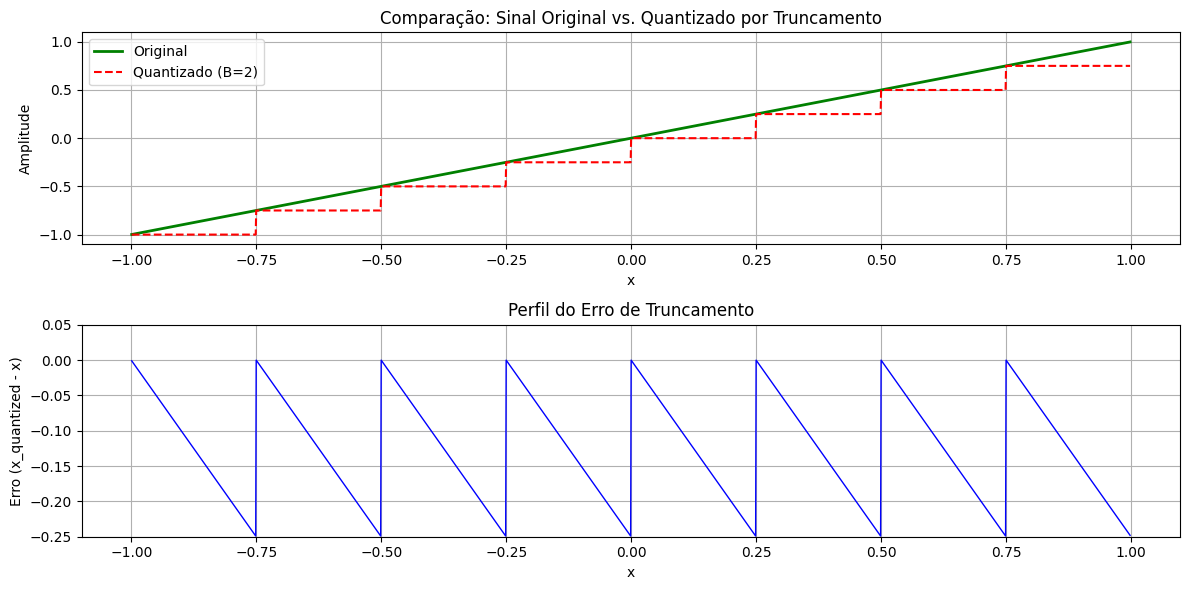

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Configura√ß√£o do problema
B = 2  # N√∫mero de bits fracion√°rios
delta = 2**(-B)  # Resolu√ß√£o = 0.25

# Gera√ß√£o do sinal de entrada (evitando os extremos -1 e 1)
x = np.arange(-1 + 2**(-10), 1 - 2**(-10), 2**(-10))

# Quantiza√ß√£o por truncamento (equivalente ao 'fix' do MATLAB)
x_quantized = np.floor(x * 2**B) / 2**B

# C√°lculo do erro
error = x_quantized - x

# Gr√°fico 1: Sinal original vs. quantizado
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, x, 'g-', linewidth=2, label='Original')
plt.plot(x, x_quantized, 'r--', linewidth=1.5, label='Quantizado (B=2)')
plt.title('Compara√ß√£o: Sinal Original vs. Quantizado por Truncamento')
plt.xlabel('x'); plt.ylabel('Amplitude')
plt.legend(); plt.grid(True)

# Gr√°fico 2: Erro de quantiza√ß√£o
plt.subplot(2, 1, 2)
plt.plot(x, error, 'b', linewidth=1)
plt.title('Perfil do Erro de Truncamento')
plt.xlabel('x'); plt.ylabel('Erro (x_quantized - x)')
plt.ylim([-delta, 0.05])  # Mostrando o limite te√≥rico
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
print(f"Resolu√ß√£o te√≥rica (Œî): {delta:.4f}")
print(f"M√©dia do erro: {np.mean(error):.6f} (Te√≥rica: -Œî/2 = {-delta/2:.4f})")
print(f"Vari√¢ncia do erro: {np.var(error):.6f} (Te√≥rica: Œî¬≤/12 = {(delta**2)/12:.6f})")
print(f"Erro m√≠nimo: {np.min(error):.6f}")
print(f"Erro m√°ximo: {np.max(error):.6f}")

Resolu√ß√£o te√≥rica (Œî): 0.2500
M√©dia do erro: -0.124512 (Te√≥rica: -Œî/2 = -0.1250)
Vari√¢ncia do erro: 0.005198 (Te√≥rica: Œî¬≤/12 = 0.005208)
Erro m√≠nimo: -0.249023
Erro m√°ximo: 0.000000


# 6.8 Quantiza√ß√£o de Coeficientes de Filtros

##  Filtros IIR

### Impacto Fundamental
A quantiza√ß√£o de coeficientes em filtros IIR pode alterar radicalmente suas propriedades devido √† natureza recursiva. Os principais efeitos incluem:

1. **Deslocamento de Polos**:
   - Pequenas varia√ß√µes nos coeficientes podem mover polos para fora do c√≠rculo unit√°rio, tornando o sistema inst√°vel
   - Sensibilidade especialmente cr√≠tica em filtros de alta ordem

2. **Mudan√ßa na Resposta Temporal**:
   - Constantes de tempo alteradas
   - Poss√≠vel introdu√ß√£o de oscila√ß√µes n√£o previstas

3. **Propaga√ß√£o de Erros**:
   - Erros nos coeficientes se propagam atrav√©s das se√ß√µes recursivas
   - Efeito cumulativo em estruturas em cascata

##  Efeito nas Localiza√ß√µes de Polos e Zeros

### Mecanismo de Perturba√ß√£o
Para um filtro com fun√ß√£o de transfer√™ncia:

$$
H(z) = \frac{\sum_{k=0}^M b_k z^{-k}}{1 + \sum_{k=1}^N a_k z^{-k}}
$$

A quantiza√ß√£o altera:
- **Posi√ß√µes de zeros** (menos cr√≠tico em IIR)
- **Posi√ß√µes de polos** (altamente sens√≠vel)

### Teoria da Sensibilidade
A sensibilidade da posi√ß√£o de um polo $p_i$ em rela√ß√£o ao coeficiente $a_k$ √© dada por:

$$
\frac{\partial p_i}{\partial a_k} = -\frac{p_i^{N-k}}{\prod_{l \neq i}(p_i - p_l)}
$$

Implica√ß√µes:
1. **Polos Agrupados** ‚Üí Maior sensibilidade
2. **Ordem Elevada** ‚Üí Efeitos mais pronunciados
3. **Polos Pr√≥ximos ao C√≠rculo Unit√°rio** ‚Üí Risco de instabilidade

### Caso Pr√°tico T√≠pico
- Filtro el√≠ptico de 8¬™ ordem pode se tornar inst√°vel com 12 bits
- Filtro Butterworth mostra menor sensibilidade que Chebyshev

##  Efeitos na Resposta em Frequ√™ncia

### Altera√ß√µes Qualitativas
1. **Banda de Passagem**:
   - Varia√ß√£o no ripple
   - Mudan√ßa na frequ√™ncia de corte

2. **Banda de Rejei√ß√£o**:
   - Redu√ß√£o da atenua√ß√£o
   - Aparecimento de "l√≥bulos" extras

3. **Transi√ß√£o**:
   - Alargamento da banda de transi√ß√£o
   - Inclina√ß√£o alterada

### M√©tricas Quantitativas
- **Erro Relativo na Magnitude**:

  $$
  \delta_H(\omega) = \frac{|H_q(e^{j\omega}) - H(e^{j\omega})|}{|H(e^{j\omega})|}
  $$

- **Desvio de Fase**:
  - Cr√≠tico em aplica√ß√µes de processamento de sinais temporais

### Fatores de Influ√™ncia
| Fator | Impacto na Resposta |
|-------|---------------------|
| N√∫mero de bits | Melhoria logar√≠tmica com aumento de bits |
| Tipo de Filtro | El√≠ptico > Chebyshev > Butterworth |
| Estrutura | Cascata > Paralela > Direta |



## Exemplo 6.25: Ressonador Digital

### Sistema Original
- **Coeficientes**:
  $$ a_1 = -0.9, \quad a_2 = 0.81 $$
- **Polos**:
  $$ p_{1,2} = 0.9e^{\pm j\pi/3} $$ (raio = 0.9, √¢ngulo = ¬±60¬∞)

### Processo de Quantiza√ß√£o
A fun√ß√£o `QCoeff` realiza:
1. Determina√ß√£o autom√°tica de bits inteiros (L) e fracion√°rios (B)
2. Quantiza√ß√£o por arredondamento para N bits totais
3. Preserva√ß√£o do sinal original

In [11]:
import numpy as np

def q_coeff(x, N):
    xm = np.max(np.abs(x)) # Encontra o valor absoluto m√°ximo para determinar L
    if xm == 0: # Lidar com o caso de input zero
        L = 0
    else:
        L = np.maximum(0, np.floor(np.log2(xm) + 1)).astype(int)


    if N <= L:
        raise ValueError(f'O n√∫mero total de bits N ({N}) deve ser maior que o n√∫mero de bits inteiros necess√°rios L ({L}). Considere aumentar N.')

    B = N - L - 1 # N = 1 (sinal) + L (inteiro) + B (fracion√°rio)


    scaled_x = x * (2**B)

    # Arredondar para o inteiro mais pr√≥ximo
    rounded_x = np.round(scaled_x)

    # Escalar de volta dividindo por 2^B
    y = rounded_x / (2**B)

    return y, L, B

# Coeficientes originais
a1, a2 = -0.9, 0.81

N_bits = 4
try:
    a_quant, L, B = q_coeff(np.array([a1, a2]), N_bits)
    print(f'Coeficientes originais: [{a1}, {a2}]')
    print(f'Coeficientes quantizados ({N_bits} bits): {a_quant}')
    print(f'Bits inteiros (L): {L}, Bits fracion√°rios (B): {B}')

    # C√°lculo dos polos
    # Originais
    r = 0.9
    theta = np.pi/3
    p1 = r * np.exp(1j * theta)

    if a_quant[1] < 0:
        print("Erro: Coeficiente a_quant[1] √© negativo, polos complexos n√£o podem ser calculados desta forma.")
    else:
        r_hat = np.sqrt(a_quant[1])
        # Certifique-se que o argumento de arccos est√° entre -1 e 1
        arg_theta_hat = -a_quant[0]/(2*r_hat)
        if np.abs(arg_theta_hat) > 1:
             print(f"Erro: Argumento de arccos fora do intervalo [-1, 1]: {arg_theta_hat:.4f}")
        else:
            theta_hat = np.arccos(arg_theta_hat)
            p1_hat = r_hat * np.exp(1j * theta_hat)

            # Varia√ß√£o na posi√ß√£o dos polos
            delta_p = np.abs(p1 - p1_hat)
            print(f'Polo original: {p1:.4f}')
            print(f'Polo quantizado: {p1_hat:.4f}')
            print(f'Deslocamento do polo: {delta_p:.4f}')

except ValueError as e:
    print(f"Erro ao quantizar: {e}")

Coeficientes originais: [-0.9, 0.81]
Coeficientes quantizados (4 bits): [-0.875  0.75 ]
Bits inteiros (L): 0, Bits fracion√°rios (B): 3
Polo original: 0.4500+0.7794j
Polo quantizado: 0.4375+0.7474j
Deslocamento do polo: 0.0344
